In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from src.models import gan
 
from src.common.helperfunctions import *
from src.common.accuracy_XGboost import *


import xgboost as xgb
import time
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
file_name = 'data/raw/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [4]:
sc = StandardScaler()
train.loc[:,'Amount'] = sc.fit_transform(train.Amount.values.reshape(-1, 1))
train.loc[:,'Time'] = sc.fit_transform(train.Time.values.reshape(-1, 1))
test.loc[:,'Amount'] = sc.transform(test.Amount.values.reshape(-1, 1))
test.loc[:,'Time'] = sc.transform(test.Time.values.reshape(-1, 1))
# train.drop('Time',axis=1, inplace=True)
# test.drop('Time', axis=1, inplace=True)

C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [5]:
train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.278450e+05,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,2.278450e+05,227845.000000
mean,-1.328462e-16,0.000916,-0.000384,-0.000920,-0.001458,0.000997,-0.000613,0.001090,-0.000383,0.000961,...,0.000215,-0.001215,0.000175,-0.000217,-0.000979,-0.000192,-0.000032,0.000257,-5.624473e-16,0.001729
std,1.000002e+00,1.958337,1.656602,1.514545,1.415853,1.387667,1.336803,1.243493,1.188643,1.097553,...,0.732617,0.725311,0.627103,0.605446,0.521764,0.482443,0.401821,0.329776,1.000002e+00,0.041548
min,-1.996122e+00,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,-3.470760e-01,0.000000
25%,-8.556106e-01,-0.919918,-0.597971,-0.890786,-0.849270,-0.688802,-0.768573,-0.552156,-0.208431,-0.642386,...,-0.228730,-0.542809,-0.161296,-0.354887,-0.317835,-0.327476,-0.070960,-0.052980,-3.251092e-01,0.000000
50%,-2.123794e-01,0.017978,0.066050,0.179041,-0.020959,-0.054711,-0.274846,0.041272,0.022233,-0.050414,...,-0.029639,0.005491,-0.010595,0.040766,0.015101,-0.052011,0.001359,0.011366,-2.607777e-01,0.000000
75%,9.373337e-01,1.315548,0.803898,1.025399,0.741630,0.611173,0.396056,0.570639,0.327504,0.599040,...,0.186080,0.527408,0.148202,0.439790,0.350453,0.240813,0.091400,0.078464,-4.463973e-02,0.000000
max,1.642496e+00,2.454930,22.057729,4.187811,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.004303e+02,1.000000


In [6]:
train.drop('Time', axis = 1,inplace=True)
test.drop('Time', axis = 1,inplace=True)

C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
label_col = []
feature_cols = []
label_col = [i for i in train.columns if 'Class' in i]
feature_cols = [i for i in train.columns if i not in label_col]

In [8]:
train_Class = train[train.Class == 1]

In [9]:
# mxs = MinMaxScaler()
# train.iloc[:,:] = mxs.fit_transform(train.iloc[:,:].values)
# test.iloc[:,:] = mxs.transform(test.iloc[:,:].values)
# # train.drop('Time',axis=1, inplace=True)
# # test.drop('Time', axis=1, inplace=True)

# Train GAN

In [10]:
train_Class.drop('Class', axis = 1,inplace=True)

In [11]:
train_Class.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [12]:
dataloader = prepareDataset(train_Class, batch_size = 128, device = 'cpu', withLabel = False)

In [13]:
dataloader.dataset.features.size(1)

29

Generator(
  (main): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=256, out_features=29, bias=True)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=29, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Starting Training Loop...
394 394
epoch: 0, Accuracy: 0.9289340101522843
[0/1001]	Loss_D: 0.3544	Loss_G: 0.6861	


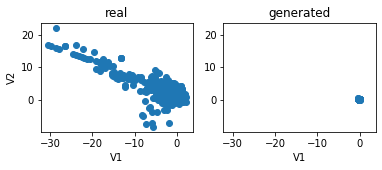

394 394
epoch: 10, Accuracy: 0.9543147208121827
[10/1001]	Loss_D: 0.1852	Loss_G: 1.5107	


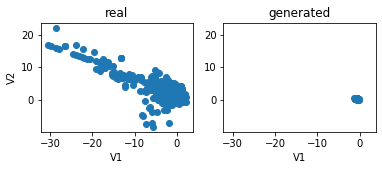

394 394
epoch: 20, Accuracy: 0.9847715736040609
[20/1001]	Loss_D: 0.4696	Loss_G: 1.4902	


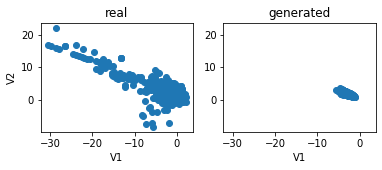

394 394
epoch: 30, Accuracy: 0.9441624365482234
[30/1001]	Loss_D: 0.5693	Loss_G: 2.2309	


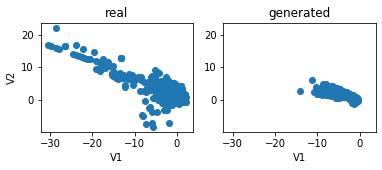

394 394
epoch: 40, Accuracy: 0.9720812182741116
[40/1001]	Loss_D: 0.7472	Loss_G: 1.3998	


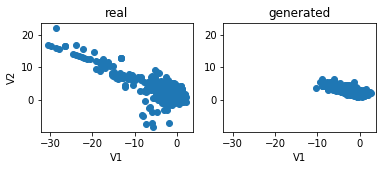

394 394
epoch: 50, Accuracy: 0.9873096446700508
[50/1001]	Loss_D: 0.5890	Loss_G: 1.9078	


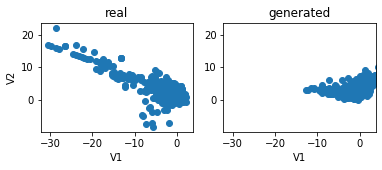

394 394
epoch: 60, Accuracy: 0.9771573604060914
[60/1001]	Loss_D: 0.8604	Loss_G: 1.5903	


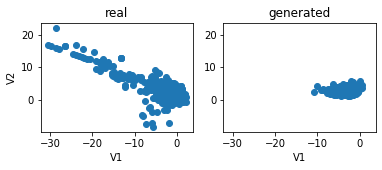

394 394
epoch: 70, Accuracy: 0.9593908629441624
[70/1001]	Loss_D: 0.4680	Loss_G: 1.6904	


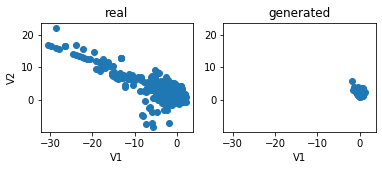

394 394
epoch: 80, Accuracy: 0.7741116751269036
[80/1001]	Loss_D: 0.5329	Loss_G: 2.0541	


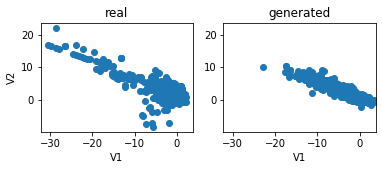

394 394
epoch: 90, Accuracy: 0.9644670050761421
[90/1001]	Loss_D: 0.6330	Loss_G: 0.9612	


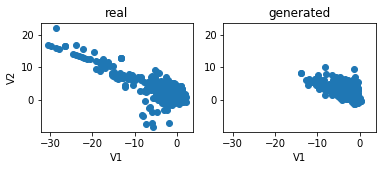

394 394
epoch: 100, Accuracy: 0.9847715736040609
[100/1001]	Loss_D: 0.6080	Loss_G: 1.1716	


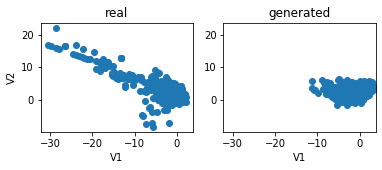

394 394
epoch: 110, Accuracy: 0.9390862944162437
[110/1001]	Loss_D: 0.7283	Loss_G: 1.4566	


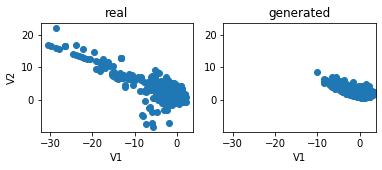

394 394
epoch: 120, Accuracy: 0.9467005076142132
[120/1001]	Loss_D: 0.5497	Loss_G: 1.1998	


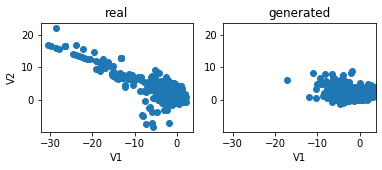

394 394
epoch: 130, Accuracy: 0.9644670050761421
[130/1001]	Loss_D: 0.6762	Loss_G: 1.1151	


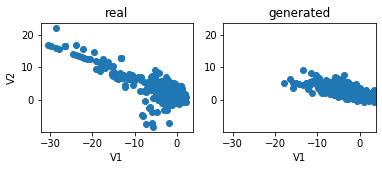

394 394
epoch: 140, Accuracy: 0.9619289340101523
[140/1001]	Loss_D: 0.6174	Loss_G: 1.5841	


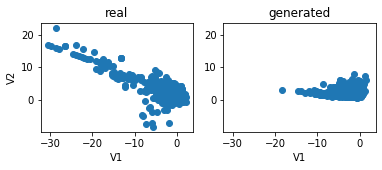

394 394
epoch: 150, Accuracy: 0.9568527918781726
[150/1001]	Loss_D: 0.6564	Loss_G: 1.3412	


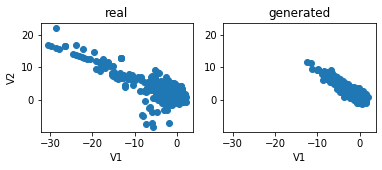

394 394
epoch: 160, Accuracy: 0.9568527918781726
[160/1001]	Loss_D: 0.5508	Loss_G: 1.4214	


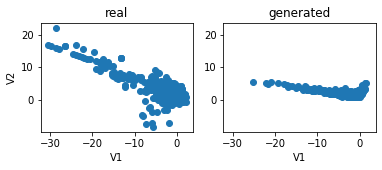

394 394
epoch: 170, Accuracy: 0.9441624365482234
[170/1001]	Loss_D: 0.4668	Loss_G: 1.4224	


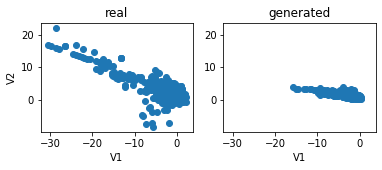

394 394
epoch: 180, Accuracy: 0.949238578680203
[180/1001]	Loss_D: 0.6012	Loss_G: 1.2546	


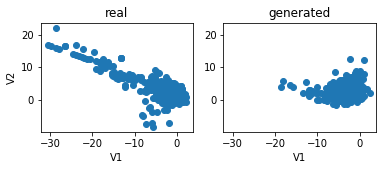

394 394
epoch: 190, Accuracy: 0.9441624365482234
[190/1001]	Loss_D: 0.6378	Loss_G: 1.3122	


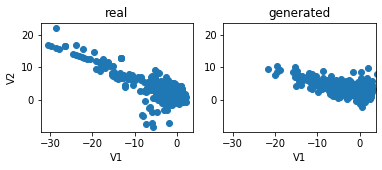

394 394
epoch: 200, Accuracy: 0.9213197969543148
[200/1001]	Loss_D: 0.4708	Loss_G: 1.1221	


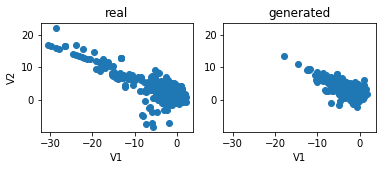

394 394
epoch: 210, Accuracy: 0.9593908629441624
[210/1001]	Loss_D: 0.5679	Loss_G: 1.2527	


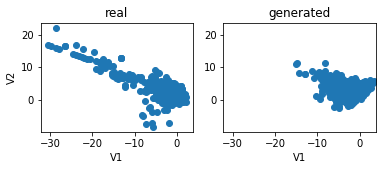

394 394
epoch: 220, Accuracy: 0.9644670050761421
[220/1001]	Loss_D: 0.5620	Loss_G: 1.2965	


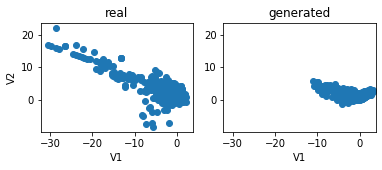

394 394
epoch: 230, Accuracy: 0.9111675126903553
[230/1001]	Loss_D: 0.6205	Loss_G: 1.3860	


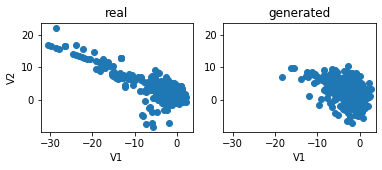

394 394
epoch: 240, Accuracy: 0.9695431472081218
[240/1001]	Loss_D: 0.6091	Loss_G: 1.1457	


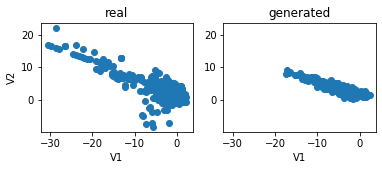

394 394
epoch: 250, Accuracy: 0.9619289340101523
[250/1001]	Loss_D: 0.5172	Loss_G: 1.3963	


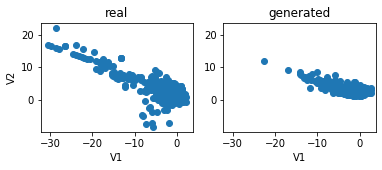

394 394
epoch: 260, Accuracy: 0.9289340101522843
[260/1001]	Loss_D: 0.5493	Loss_G: 1.3555	


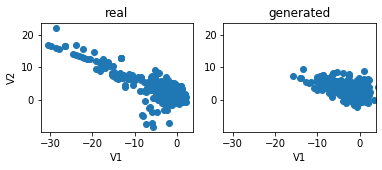

394 394
epoch: 270, Accuracy: 0.9568527918781726
[270/1001]	Loss_D: 0.6077	Loss_G: 1.1477	


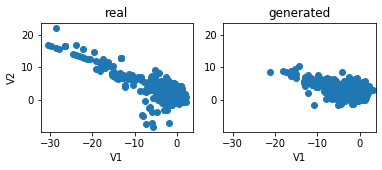

394 394
epoch: 280, Accuracy: 0.9314720812182741
[280/1001]	Loss_D: 0.5608	Loss_G: 1.3871	


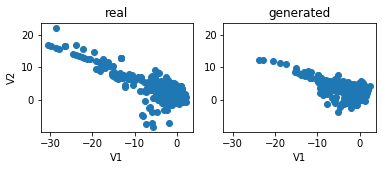

394 394
epoch: 290, Accuracy: 0.883248730964467
[290/1001]	Loss_D: 0.6371	Loss_G: 1.4569	


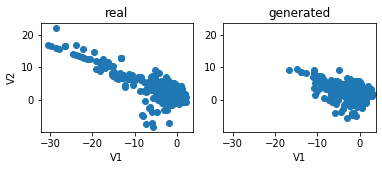

394 394
epoch: 300, Accuracy: 0.8984771573604061
[300/1001]	Loss_D: 0.5915	Loss_G: 1.2899	


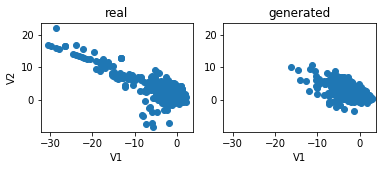

394 394
epoch: 310, Accuracy: 0.916243654822335
[310/1001]	Loss_D: 0.6018	Loss_G: 1.5019	


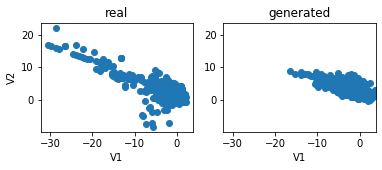

394 394
epoch: 320, Accuracy: 0.9416243654822335
[320/1001]	Loss_D: 0.6016	Loss_G: 1.6439	


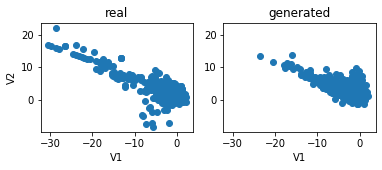

394 394
epoch: 330, Accuracy: 0.9314720812182741
[330/1001]	Loss_D: 0.5206	Loss_G: 1.5371	


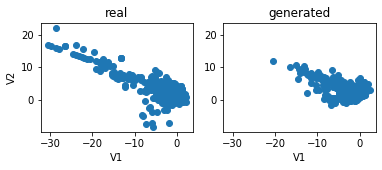

394 394
epoch: 340, Accuracy: 0.8959390862944162
[340/1001]	Loss_D: 0.5441	Loss_G: 1.4998	


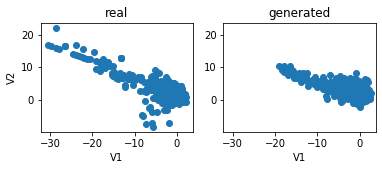

394 394
epoch: 350, Accuracy: 0.9086294416243654
[350/1001]	Loss_D: 0.5968	Loss_G: 1.5849	


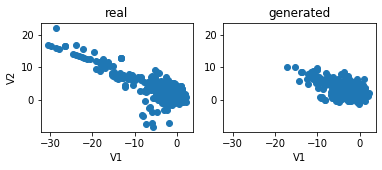

394 394
epoch: 360, Accuracy: 0.9365482233502538
[360/1001]	Loss_D: 0.5311	Loss_G: 1.3710	


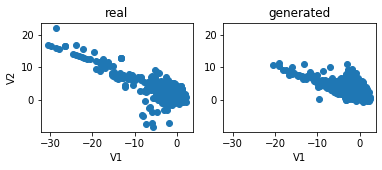

394 394
epoch: 370, Accuracy: 0.9365482233502538
[370/1001]	Loss_D: 0.5968	Loss_G: 1.6224	


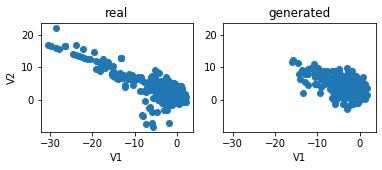

394 394
epoch: 380, Accuracy: 0.9593908629441624
[380/1001]	Loss_D: 0.6362	Loss_G: 1.4362	


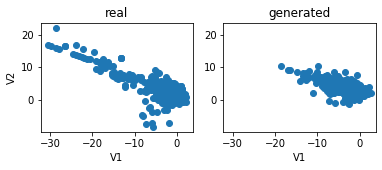

394 394
epoch: 390, Accuracy: 0.916243654822335
[390/1001]	Loss_D: 0.5071	Loss_G: 1.5650	


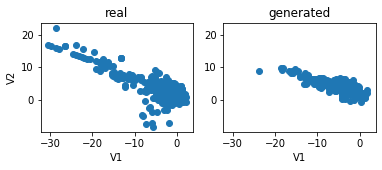

394 394
epoch: 400, Accuracy: 0.9314720812182741
[400/1001]	Loss_D: 0.4773	Loss_G: 1.6051	


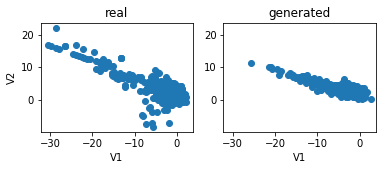

394 394
epoch: 410, Accuracy: 0.916243654822335
[410/1001]	Loss_D: 0.5107	Loss_G: 1.4693	


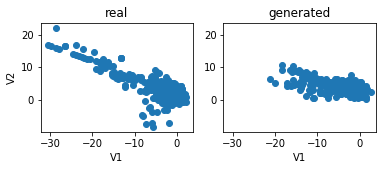

394 394
epoch: 420, Accuracy: 0.9441624365482234
[420/1001]	Loss_D: 0.5187	Loss_G: 1.3699	


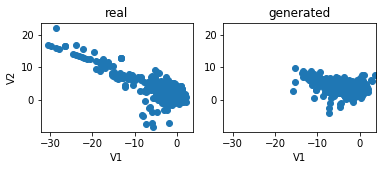

394 394
epoch: 430, Accuracy: 0.8857868020304569
[430/1001]	Loss_D: 0.6659	Loss_G: 1.1842	


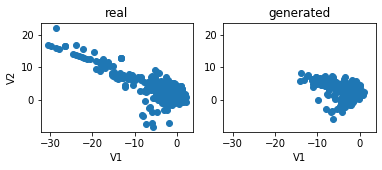

394 394
epoch: 440, Accuracy: 0.934010152284264
[440/1001]	Loss_D: 0.5011	Loss_G: 1.4625	


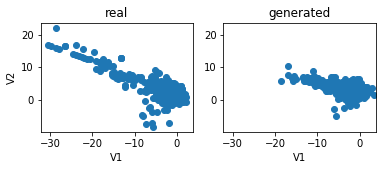

394 394
epoch: 450, Accuracy: 0.9263959390862944
[450/1001]	Loss_D: 0.4779	Loss_G: 1.4778	


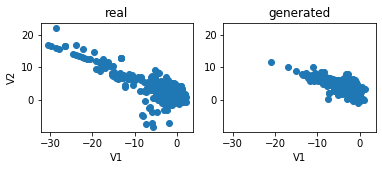

394 394
epoch: 460, Accuracy: 0.9111675126903553
[460/1001]	Loss_D: 0.4959	Loss_G: 1.6693	


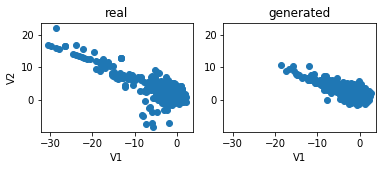

394 394
epoch: 470, Accuracy: 0.8908629441624365
[470/1001]	Loss_D: 0.5566	Loss_G: 1.7487	


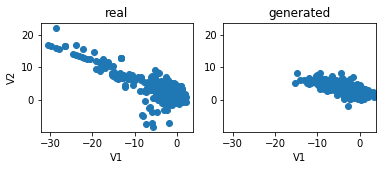

394 394
epoch: 480, Accuracy: 0.9035532994923858
[480/1001]	Loss_D: 0.6198	Loss_G: 1.5254	


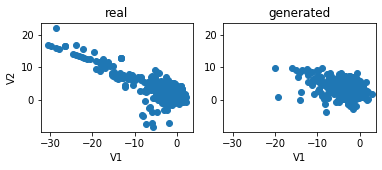

394 394
epoch: 490, Accuracy: 0.8527918781725888
[490/1001]	Loss_D: 0.4878	Loss_G: 1.5121	


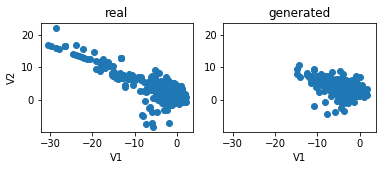

394 394
epoch: 500, Accuracy: 0.9137055837563451
[500/1001]	Loss_D: 0.5323	Loss_G: 1.5348	


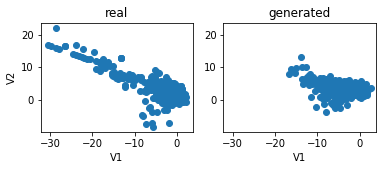

394 394
epoch: 510, Accuracy: 0.8959390862944162
[510/1001]	Loss_D: 0.6935	Loss_G: 1.6353	


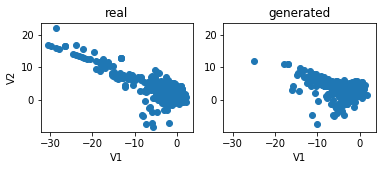

394 394
epoch: 520, Accuracy: 0.8857868020304569
[520/1001]	Loss_D: 0.4642	Loss_G: 1.8651	


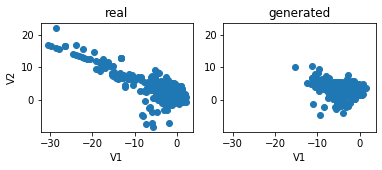

394 394
epoch: 530, Accuracy: 0.9111675126903553
[530/1001]	Loss_D: 0.4419	Loss_G: 1.8268	


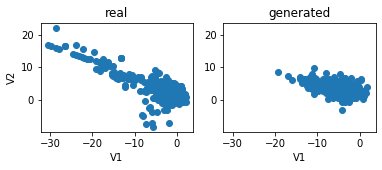

394 394
epoch: 540, Accuracy: 0.8426395939086294
[540/1001]	Loss_D: 0.5053	Loss_G: 2.0098	


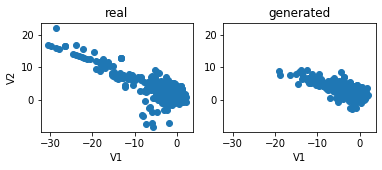

394 394
epoch: 550, Accuracy: 0.8705583756345178
[550/1001]	Loss_D: 0.3999	Loss_G: 1.9543	


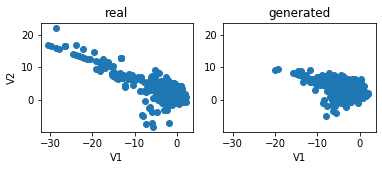

394 394
epoch: 560, Accuracy: 0.7944162436548223
[560/1001]	Loss_D: 0.4496	Loss_G: 2.3666	


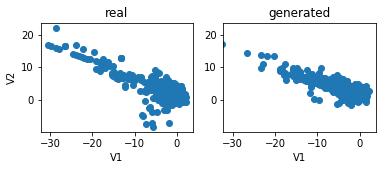

394 394
epoch: 570, Accuracy: 0.9238578680203046
[570/1001]	Loss_D: 0.3828	Loss_G: 1.7028	


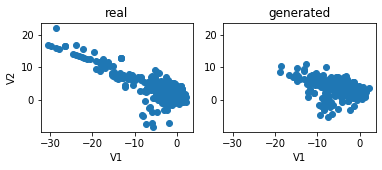

394 394
epoch: 580, Accuracy: 0.916243654822335
[580/1001]	Loss_D: 0.3864	Loss_G: 1.7659	


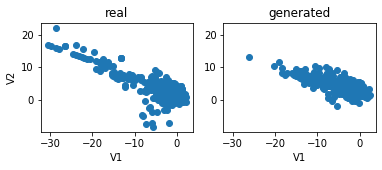

394 394
epoch: 590, Accuracy: 0.8756345177664975
[590/1001]	Loss_D: 0.3846	Loss_G: 2.1035	


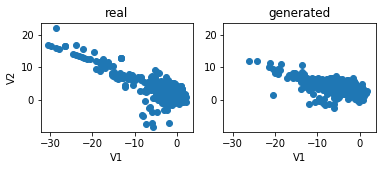

394 394
epoch: 600, Accuracy: 0.9238578680203046
[600/1001]	Loss_D: 0.5072	Loss_G: 2.0091	


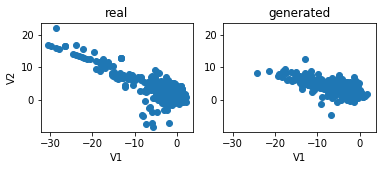

394 394
epoch: 610, Accuracy: 0.8807106598984772
[610/1001]	Loss_D: 0.4326	Loss_G: 2.0668	


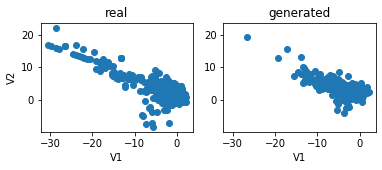

394 394
epoch: 620, Accuracy: 0.883248730964467
[620/1001]	Loss_D: 0.3670	Loss_G: 1.7976	


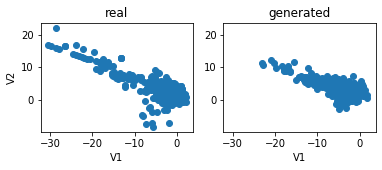

394 394
epoch: 630, Accuracy: 0.9137055837563451
[630/1001]	Loss_D: 0.4506	Loss_G: 2.0885	


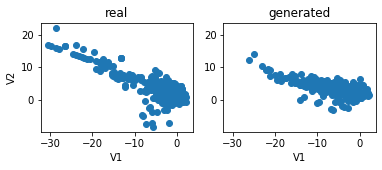

394 394
epoch: 640, Accuracy: 0.9137055837563451
[640/1001]	Loss_D: 0.3610	Loss_G: 2.1182	


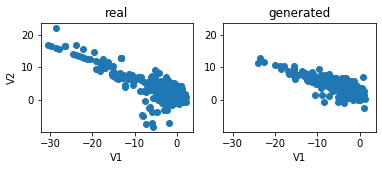

394 394
epoch: 650, Accuracy: 0.9187817258883249
[650/1001]	Loss_D: 0.4068	Loss_G: 1.8943	


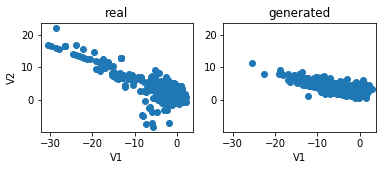

394 394
epoch: 660, Accuracy: 0.8959390862944162
[660/1001]	Loss_D: 0.3687	Loss_G: 2.2556	


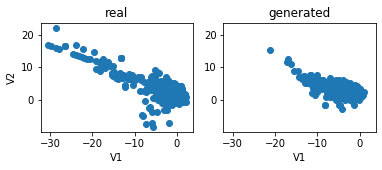

394 394
epoch: 670, Accuracy: 0.883248730964467
[670/1001]	Loss_D: 0.3493	Loss_G: 2.2665	


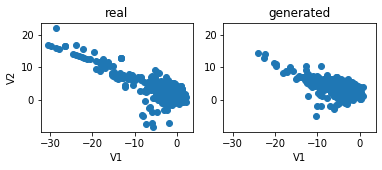

394 394
epoch: 680, Accuracy: 0.8857868020304569
[680/1001]	Loss_D: 0.3295	Loss_G: 2.1297	


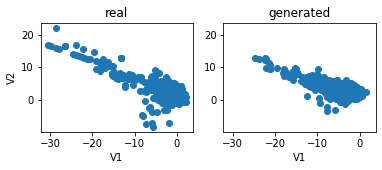

394 394
epoch: 690, Accuracy: 0.9390862944162437
[690/1001]	Loss_D: 0.3504	Loss_G: 2.1590	


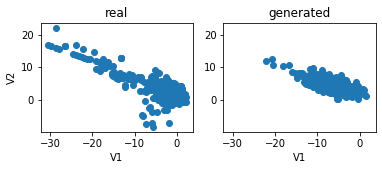

394 394
epoch: 700, Accuracy: 0.9365482233502538
[700/1001]	Loss_D: 0.3699	Loss_G: 2.4799	


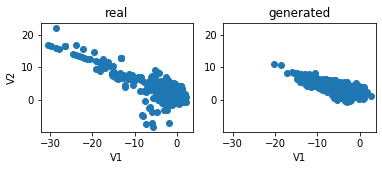

394 394
epoch: 710, Accuracy: 0.8984771573604061
[710/1001]	Loss_D: 0.3957	Loss_G: 1.9413	


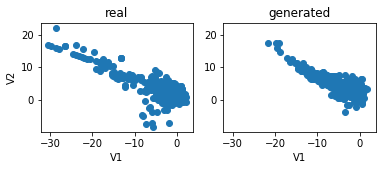

394 394
epoch: 720, Accuracy: 0.8883248730964467
[720/1001]	Loss_D: 0.4012	Loss_G: 2.3075	


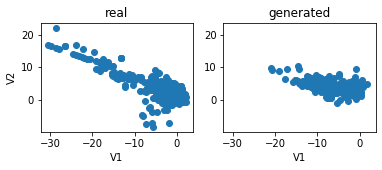

394 394
epoch: 730, Accuracy: 0.868020304568528
[730/1001]	Loss_D: 0.3033	Loss_G: 2.3565	


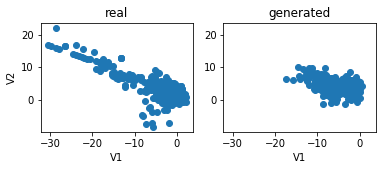

394 394
epoch: 740, Accuracy: 0.8883248730964467
[740/1001]	Loss_D: 0.3015	Loss_G: 2.4475	


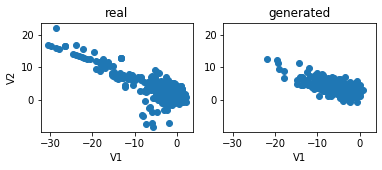

394 394
epoch: 750, Accuracy: 0.9289340101522843
[750/1001]	Loss_D: 0.3377	Loss_G: 2.4666	


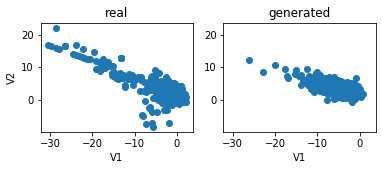

394 394
epoch: 760, Accuracy: 0.9238578680203046
[760/1001]	Loss_D: 0.2843	Loss_G: 2.4208	


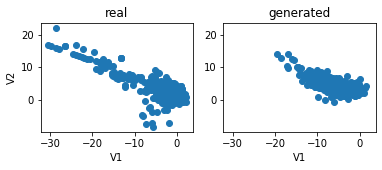

394 394
epoch: 770, Accuracy: 0.9035532994923858
[770/1001]	Loss_D: 0.3350	Loss_G: 2.3558	


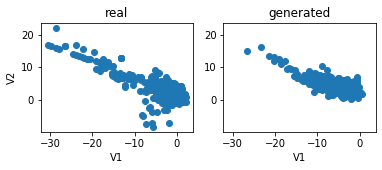

394 394
epoch: 780, Accuracy: 0.8604060913705583
[780/1001]	Loss_D: 0.3327	Loss_G: 2.6442	


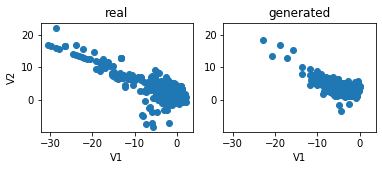

394 394
epoch: 790, Accuracy: 0.8756345177664975
[790/1001]	Loss_D: 0.2976	Loss_G: 2.5886	


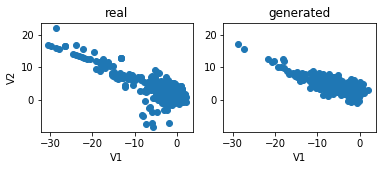

394 394
epoch: 800, Accuracy: 0.9137055837563451
[800/1001]	Loss_D: 0.3721	Loss_G: 2.4478	


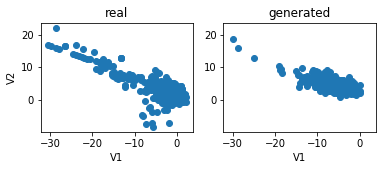

394 394
epoch: 810, Accuracy: 0.9187817258883249
[810/1001]	Loss_D: 0.3734	Loss_G: 1.6466	


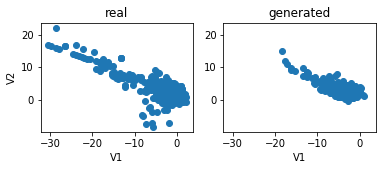

394 394
epoch: 820, Accuracy: 0.9213197969543148
[820/1001]	Loss_D: 0.2970	Loss_G: 2.3839	


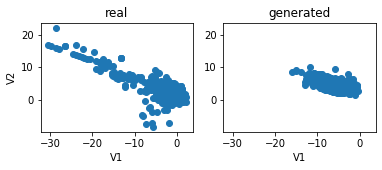

394 394
epoch: 830, Accuracy: 0.9060913705583756
[830/1001]	Loss_D: 0.2720	Loss_G: 2.4594	


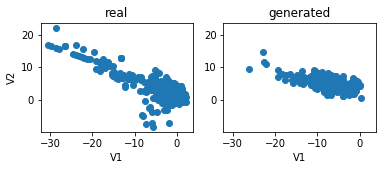

394 394
epoch: 840, Accuracy: 0.9060913705583756
[840/1001]	Loss_D: 0.2949	Loss_G: 2.6077	


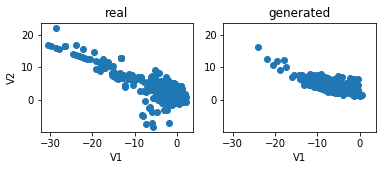

394 394
epoch: 850, Accuracy: 0.8959390862944162
[850/1001]	Loss_D: 0.2686	Loss_G: 2.5459	


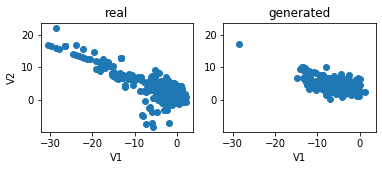

394 394
epoch: 860, Accuracy: 0.916243654822335
[860/1001]	Loss_D: 0.2684	Loss_G: 2.6214	


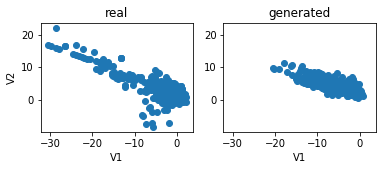

394 394
epoch: 870, Accuracy: 0.8984771573604061
[870/1001]	Loss_D: 0.2734	Loss_G: 2.5852	


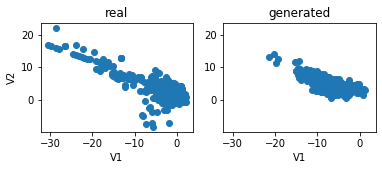

394 394
epoch: 880, Accuracy: 0.8350253807106599
[880/1001]	Loss_D: 0.2955	Loss_G: 2.9621	


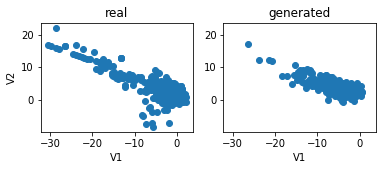

394 394
epoch: 890, Accuracy: 0.8857868020304569
[890/1001]	Loss_D: 0.3181	Loss_G: 2.8696	


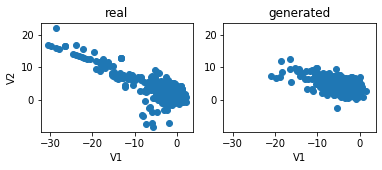

394 394
epoch: 900, Accuracy: 0.9213197969543148
[900/1001]	Loss_D: 0.2553	Loss_G: 2.8211	


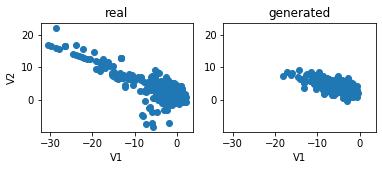

394 394
epoch: 910, Accuracy: 0.8934010152284264
[910/1001]	Loss_D: 0.2853	Loss_G: 2.8762	


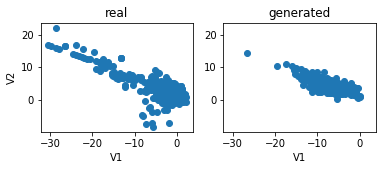

394 394
epoch: 920, Accuracy: 0.9289340101522843
[920/1001]	Loss_D: 0.2518	Loss_G: 3.0556	


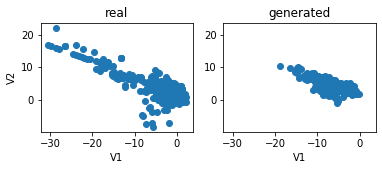

394 394
epoch: 930, Accuracy: 0.8883248730964467
[930/1001]	Loss_D: 0.2727	Loss_G: 2.7445	


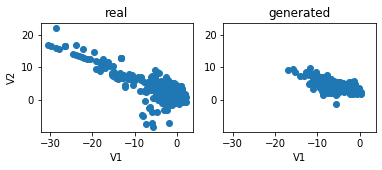

394 394
epoch: 940, Accuracy: 0.916243654822335
[940/1001]	Loss_D: 0.2456	Loss_G: 2.7188	


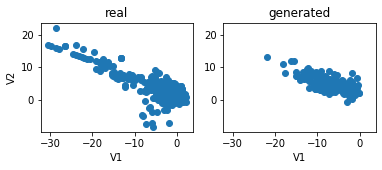

394 394
epoch: 950, Accuracy: 0.9314720812182741
[950/1001]	Loss_D: 0.2246	Loss_G: 2.6923	


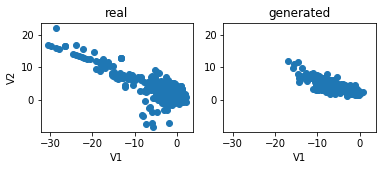

394 394
epoch: 960, Accuracy: 0.9086294416243654
[960/1001]	Loss_D: 0.4994	Loss_G: 2.2621	


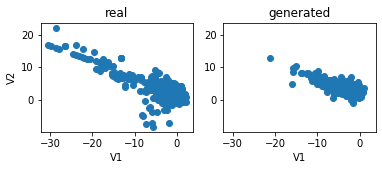

394 394
epoch: 970, Accuracy: 0.9289340101522843
[970/1001]	Loss_D: 0.2578	Loss_G: 2.5238	


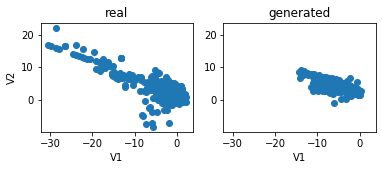

394 394
epoch: 980, Accuracy: 0.8756345177664975
[980/1001]	Loss_D: 0.2755	Loss_G: 3.0015	


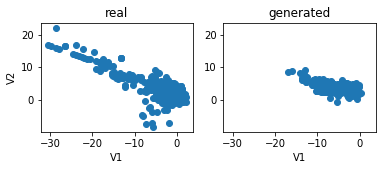

394 394
epoch: 990, Accuracy: 0.9187817258883249
[990/1001]	Loss_D: 0.2522	Loss_G: 2.4192	


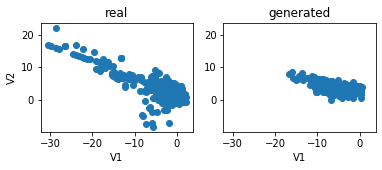

394 394
epoch: 1000, Accuracy: 0.8756345177664975
[1000/1001]	Loss_D: 0.2911	Loss_G: 2.9239	


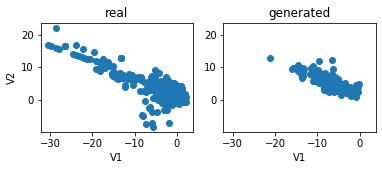

It took  63.90904998779297


In [14]:
xgblosses, D_losses, G_losses, D_RealLosses, D_FakeLosses, generated_data, real_data_list = gan.train(dataloader, randomNoise_dim = 32, hidden_dim = 64, realData_dim =dataloader.dataset.features.size(1), lr = 0.002, num_epochs=1000, feature_cols=feature_cols, device='cpu')

In [15]:
for i in range(xgblosses.size):
    if np.round(xgblosses[i],6) == np.round(min(xgblosses[10:]),6):
        best_round = i*10
        print(best_round)

560


0.7944162436548223


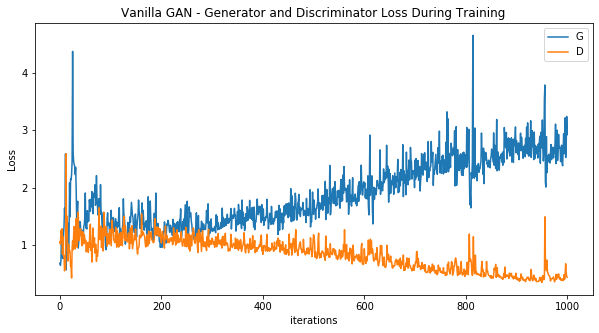

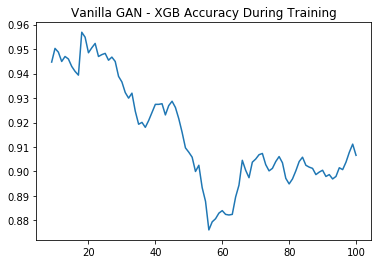

In [16]:
w=10
print(min(xgblosses[10:]))
plt.figure(figsize=(10,5))
plt.title(f"Vanilla GAN - Generator and Discriminator Loss During Training")
b = pd.DataFrame(G_losses[:]).rolling(w).mean()
# c = pd.DataFrame(D_RealLosses[:]).rolling(w).mean()
# d = pd.DataFrame(D_FakeLosses[:]).rolling(w).mean()
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
# plt.plot(b,label="G")
# plt.plot(c,label="D")
# plt.plot(d,label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f'reports/figures/gan/GAN.png')
plt.show()


a = pd.DataFrame(xgblosses[:]).rolling(w).mean()
plt.title(f"Vanilla GAN - XGB Accuracy During Training")
plt.plot(a)
plt.savefig(f'reports/figures/gan/xgblosses_GAN.png')
plt.show()

In [17]:
amount=train.shape[0]
device='cpu'

In [18]:
train.shape[0]

227845

In [19]:
randomNoise_dim = 32; hidden_dim = 64; realData_dim =dataloader.dataset.features.size(1)

In [20]:
more_data = gan.generate_data(best_round, randomNoise_dim, hidden_dim, realData_dim, amount, 'cpu')

In [21]:
more_data = more_data.detach().numpy()

In [22]:
b = np.ones((more_data.shape[0],more_data.shape[1]+1))
b[:,:-1] = more_data

In [23]:
b.shape

(227845, 30)

In [24]:
# label_col = ['Class']

In [25]:
df_generatedData = pd.DataFrame(b, columns = feature_cols + label_col)
df_generatedData.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-3.677720,2.715556,-6.738196,4.089111,-4.061270,-0.315547,-1.376518,1.282699,-3.489295,-7.921749,...,1.152180,-0.974094,-0.108354,-0.523099,0.777408,-0.048765,1.065879,0.555327,2.769131,1.0
1,-13.850236,6.956603,-13.768825,8.014134,-10.433500,-1.066955,-16.082960,2.858678,-8.890650,-12.114339,...,-1.761418,0.483508,-1.379451,0.323059,-1.268468,-0.678078,-0.402567,-0.194925,0.019928,1.0
2,-1.544165,0.690133,-2.468449,2.962266,-2.917859,0.632631,0.444812,0.093395,-0.999287,-3.824348,...,0.717323,-0.137792,-0.220445,-0.464224,0.114686,-0.254260,0.952241,0.295052,2.057315,1.0
3,-8.414020,4.792017,-8.770749,5.789165,-7.551833,-1.547488,-8.501342,5.156198,-5.739235,-8.784604,...,1.653292,-0.612906,-1.118170,0.425918,-0.466710,-0.474116,-0.290483,0.133093,0.719291,1.0
4,-0.860649,1.351951,-0.992415,2.122554,-1.763593,-0.468747,-2.261227,0.403601,-0.310054,-3.028222,...,0.205877,0.746146,-0.559959,0.069141,0.172873,0.170003,0.752236,0.274910,-0.444930,1.0


In [26]:
train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [27]:
train = train.append(df_generatedData)
train = train.sample(frac=1)

In [28]:
train_y = train.Class

In [29]:
train_X = train

In [30]:
train_X.drop('Class', axis=1, inplace=True)

# XGBoost

In [31]:
train_X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
211794,-4.028270,3.965968,-6.531621,6.220432,-6.040281,-2.144267,-8.749128,3.502087,-3.657313,-8.185031,...,0.438773,1.422620,0.471666,-0.088464,0.622448,-0.438265,-0.193287,1.034834,0.847506,-0.606389
95959,-6.386700,6.752539,-6.488503,7.167908,-4.893871,3.112642,-13.262729,-11.067869,-5.778970,-7.503170,...,3.447254,-7.422864,3.072204,-0.260337,-1.050422,-1.641781,-0.247823,1.152767,-0.109771,-0.933673
80820,-1.804950,1.194318,0.956449,0.257000,-1.099243,-0.623890,0.781424,0.268273,0.215597,-0.037003,...,0.038307,-0.242728,-0.284769,-0.062664,0.759304,0.058870,0.224704,0.391549,0.196488,0.180324
226479,-3.053507,-1.310128,0.073854,-1.690010,-1.200021,1.084045,2.274054,0.137295,0.100812,-1.665852,...,-0.964043,-0.719465,-1.098400,1.351974,0.216324,0.688570,0.479758,0.144417,-0.283579,1.735223
149853,-0.669364,3.155083,-4.417858,5.137841,-0.423020,-2.040413,-2.209932,1.090922,-2.569003,-4.428497,...,0.531108,0.065552,-0.731827,-0.454572,0.157152,0.772198,0.170263,0.488193,0.530090,-0.839381


In [32]:
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [33]:
train_y.shape

(455690,)

In [34]:
start_time = time.time()
dtrain = xgb.DMatrix(train_X, train_y, feature_names=feature_cols)
dtest = xgb.DMatrix(test_X, feature_names=feature_cols)

results_dict = {}

param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }

model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = np.round(model.predict(dtest))
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

C:\Users\chinne\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\chinne\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Time elapsed to train:  49.100502729415894


In [35]:
print('---' * 45)
print('XGBoost ROC/AUC: {:.6f}'.format(roc_auc_score(test_y, preds)))
print('Recall Score: {:.6f}'.format(recall_score(test_y, preds)))
print('Precision Score: {:.6f}'.format(precision_score(test_y, preds)))
print('F1 Score: {:.6f}'.format(f1_score(test_y, preds)))
print('Accuracy Score: {:.6f}'.format(accuracy_score(test_y, preds)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
XGBoost ROC/AUC: 0.807869
Recall Score: 0.928571
Precision Score: 0.005089
F1 Score: 0.010123
Accuracy Score: 0.687581
---------------------------------------------------------------------------------------------------------------------------------------


## With Time

In [36]:
file_name = 'data/raw/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [37]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [38]:
sc = StandardScaler()
train.loc[:,'Amount'] = sc.fit_transform(train.Amount.values.reshape(-1, 1))
train.loc[:,'Time'] = sc.fit_transform(train.Time.values.reshape(-1, 1))
test.loc[:,'Amount'] = sc.transform(test.Amount.values.reshape(-1, 1))
test.loc[:,'Time'] = sc.transform(test.Time.values.reshape(-1, 1))

C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [39]:
train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.278450e+05,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,2.278450e+05,227845.000000
mean,-1.328462e-16,0.000916,-0.000384,-0.000920,-0.001458,0.000997,-0.000613,0.001090,-0.000383,0.000961,...,0.000215,-0.001215,0.000175,-0.000217,-0.000979,-0.000192,-0.000032,0.000257,-5.624473e-16,0.001729
std,1.000002e+00,1.958337,1.656602,1.514545,1.415853,1.387667,1.336803,1.243493,1.188643,1.097553,...,0.732617,0.725311,0.627103,0.605446,0.521764,0.482443,0.401821,0.329776,1.000002e+00,0.041548
min,-1.996122e+00,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,-3.470760e-01,0.000000
25%,-8.556106e-01,-0.919918,-0.597971,-0.890786,-0.849270,-0.688802,-0.768573,-0.552156,-0.208431,-0.642386,...,-0.228730,-0.542809,-0.161296,-0.354887,-0.317835,-0.327476,-0.070960,-0.052980,-3.251092e-01,0.000000
50%,-2.123794e-01,0.017978,0.066050,0.179041,-0.020959,-0.054711,-0.274846,0.041272,0.022233,-0.050414,...,-0.029639,0.005491,-0.010595,0.040766,0.015101,-0.052011,0.001359,0.011366,-2.607777e-01,0.000000
75%,9.373337e-01,1.315548,0.803898,1.025399,0.741630,0.611173,0.396056,0.570639,0.327504,0.599040,...,0.186080,0.527408,0.148202,0.439790,0.350453,0.240813,0.091400,0.078464,-4.463973e-02,0.000000
max,1.642496e+00,2.454930,22.057729,4.187811,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.004303e+02,1.000000


In [40]:
train_Class = train[train.Class == 1]

In [41]:
train_Class.drop('Class', axis = 1,inplace=True)

C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [42]:
label_col = []
feature_cols = []
# label_col = ['Class']
feature_cols = [i for i in train_Class.columns if i not in label_col]

In [43]:
dataloader = prepareDataset(train_Class, batch_size = 128, device = 'cpu', withLabel = False)

Generator(
  (main): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=256, out_features=30, bias=True)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Starting Training Loop...
394 394
epoch: 0, Accuracy: 0.8477157360406091
[0/1001]	Loss_D: 0.2992	Loss_G: 0.6467	


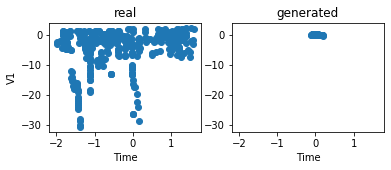

394 394
epoch: 10, Accuracy: 0.6725888324873096
[10/1001]	Loss_D: 0.2416	Loss_G: 2.5716	


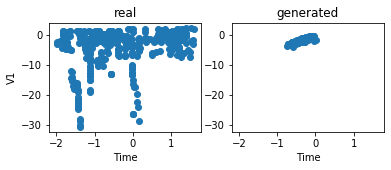

394 394
epoch: 20, Accuracy: 0.9796954314720813
[20/1001]	Loss_D: 0.1366	Loss_G: 3.4055	


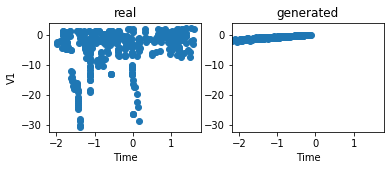

394 394
epoch: 30, Accuracy: 0.9238578680203046
[30/1001]	Loss_D: 0.4826	Loss_G: 2.0468	


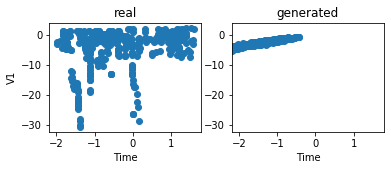

394 394
epoch: 40, Accuracy: 0.9619289340101523
[40/1001]	Loss_D: 0.8022	Loss_G: 1.5526	


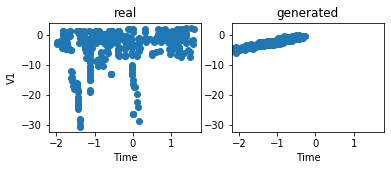

394 394
epoch: 50, Accuracy: 0.9771573604060914
[50/1001]	Loss_D: 0.5757	Loss_G: 2.0649	


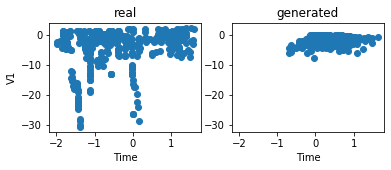

394 394
epoch: 60, Accuracy: 0.9873096446700508
[60/1001]	Loss_D: 0.5778	Loss_G: 2.2348	


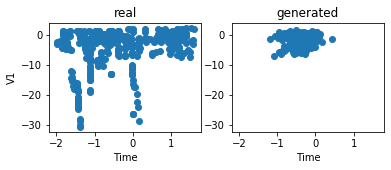

394 394
epoch: 70, Accuracy: 0.9796954314720813
[70/1001]	Loss_D: 0.4469	Loss_G: 2.2979	


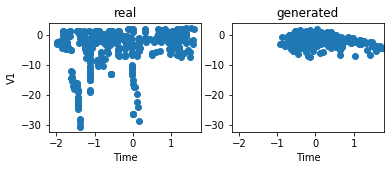

394 394
epoch: 80, Accuracy: 0.9847715736040609
[80/1001]	Loss_D: 0.6000	Loss_G: 2.1919	


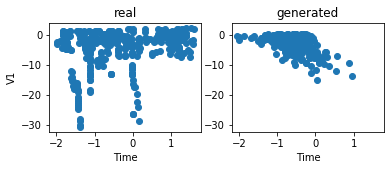

394 394
epoch: 90, Accuracy: 0.9543147208121827
[90/1001]	Loss_D: 0.4346	Loss_G: 1.6050	


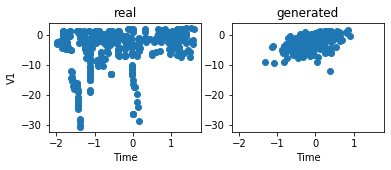

394 394
epoch: 100, Accuracy: 0.9720812182741116
[100/1001]	Loss_D: 0.4996	Loss_G: 1.2338	


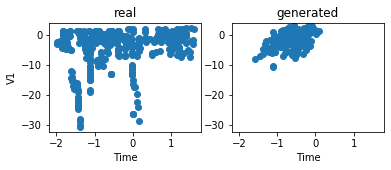

394 394
epoch: 110, Accuracy: 0.9796954314720813
[110/1001]	Loss_D: 0.5100	Loss_G: 1.3318	


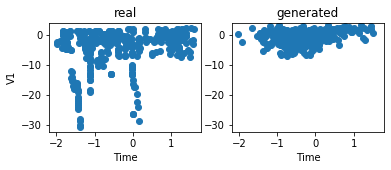

394 394
epoch: 120, Accuracy: 0.949238578680203
[120/1001]	Loss_D: 0.6153	Loss_G: 1.6064	


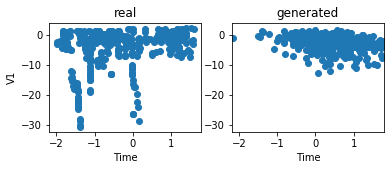

394 394
epoch: 130, Accuracy: 0.949238578680203
[130/1001]	Loss_D: 0.5578	Loss_G: 1.1224	


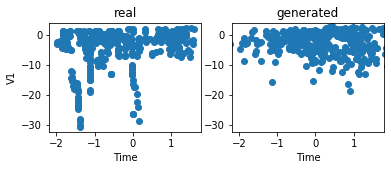

394 394
epoch: 140, Accuracy: 0.9847715736040609
[140/1001]	Loss_D: 0.6577	Loss_G: 1.3389	


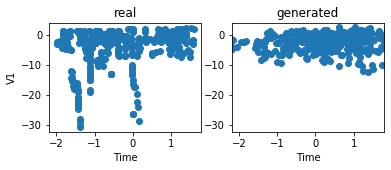

394 394
epoch: 150, Accuracy: 0.9644670050761421
[150/1001]	Loss_D: 0.5013	Loss_G: 1.5264	


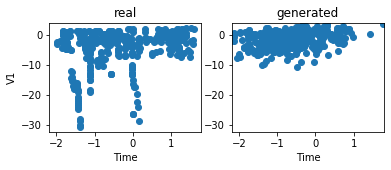

394 394
epoch: 160, Accuracy: 0.9619289340101523
[160/1001]	Loss_D: 0.6010	Loss_G: 1.4462	


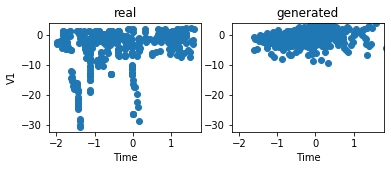

394 394
epoch: 170, Accuracy: 0.9619289340101523
[170/1001]	Loss_D: 0.5966	Loss_G: 1.4354	


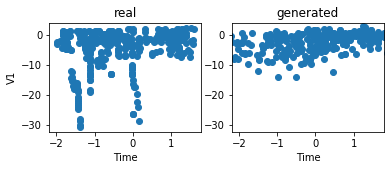

394 394
epoch: 180, Accuracy: 0.9593908629441624
[180/1001]	Loss_D: 0.5855	Loss_G: 1.6660	


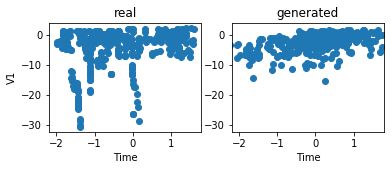

394 394
epoch: 190, Accuracy: 0.9873096446700508
[190/1001]	Loss_D: 0.5268	Loss_G: 1.3481	


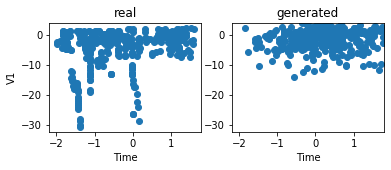

394 394
epoch: 200, Accuracy: 0.9238578680203046
[200/1001]	Loss_D: 0.4901	Loss_G: 1.2903	


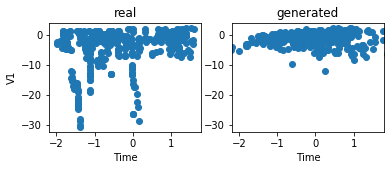

394 394
epoch: 210, Accuracy: 0.9187817258883249
[210/1001]	Loss_D: 0.5559	Loss_G: 1.3257	


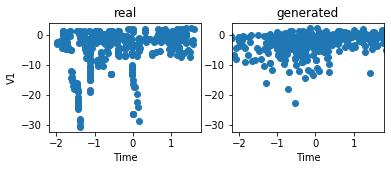

394 394
epoch: 220, Accuracy: 0.9619289340101523
[220/1001]	Loss_D: 0.7331	Loss_G: 1.4039	


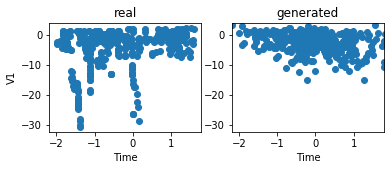

394 394
epoch: 230, Accuracy: 0.9670050761421319
[230/1001]	Loss_D: 0.4733	Loss_G: 1.5132	


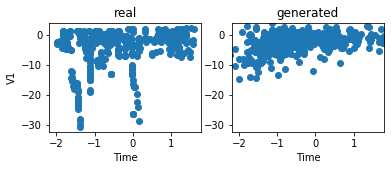

394 394
epoch: 240, Accuracy: 0.9746192893401016
[240/1001]	Loss_D: 0.6035	Loss_G: 1.4802	


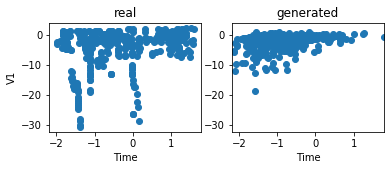

394 394
epoch: 250, Accuracy: 0.916243654822335
[250/1001]	Loss_D: 0.4981	Loss_G: 1.5213	


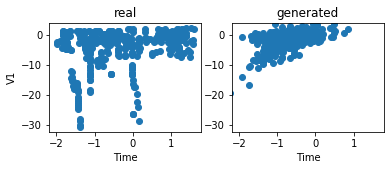

394 394
epoch: 260, Accuracy: 0.9517766497461929
[260/1001]	Loss_D: 0.5517	Loss_G: 1.3774	


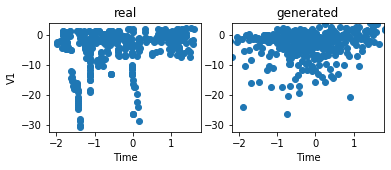

394 394
epoch: 270, Accuracy: 0.9365482233502538
[270/1001]	Loss_D: 0.4529	Loss_G: 1.4622	


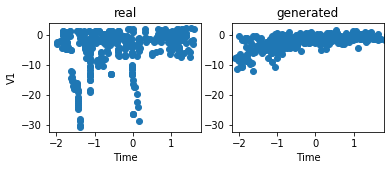

394 394
epoch: 280, Accuracy: 0.9137055837563451
[280/1001]	Loss_D: 0.4969	Loss_G: 1.7376	


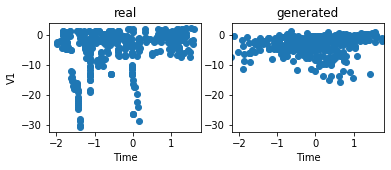

394 394
epoch: 290, Accuracy: 0.9365482233502538
[290/1001]	Loss_D: 0.4656	Loss_G: 1.3675	


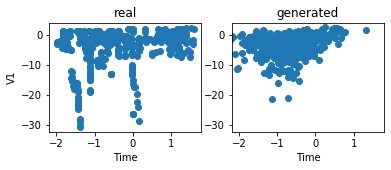

394 394
epoch: 300, Accuracy: 0.949238578680203
[300/1001]	Loss_D: 0.4272	Loss_G: 1.8658	


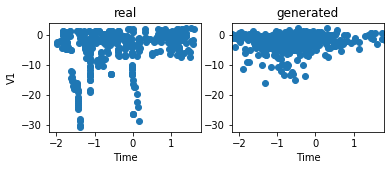

394 394
epoch: 310, Accuracy: 0.9467005076142132
[310/1001]	Loss_D: 0.5286	Loss_G: 1.4816	


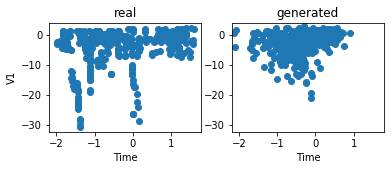

394 394
epoch: 320, Accuracy: 0.8984771573604061
[320/1001]	Loss_D: 0.5164	Loss_G: 1.5410	


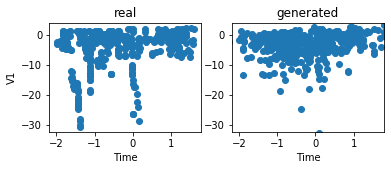

394 394
epoch: 330, Accuracy: 0.9137055837563451
[330/1001]	Loss_D: 0.3803	Loss_G: 1.6406	


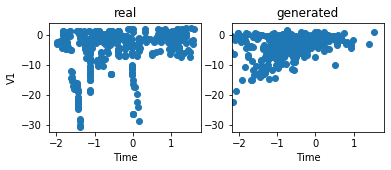

394 394
epoch: 340, Accuracy: 0.9187817258883249
[340/1001]	Loss_D: 0.5144	Loss_G: 1.4670	


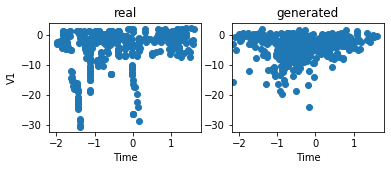

394 394
epoch: 350, Accuracy: 0.949238578680203
[350/1001]	Loss_D: 0.4452	Loss_G: 1.7008	


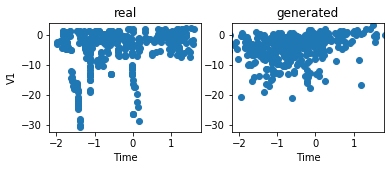

394 394
epoch: 360, Accuracy: 0.9086294416243654
[360/1001]	Loss_D: 0.4824	Loss_G: 2.1406	


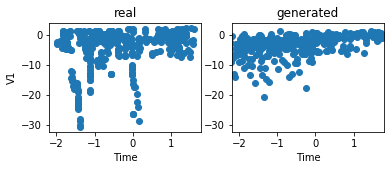

394 394
epoch: 370, Accuracy: 0.9111675126903553
[370/1001]	Loss_D: 0.5151	Loss_G: 1.4042	


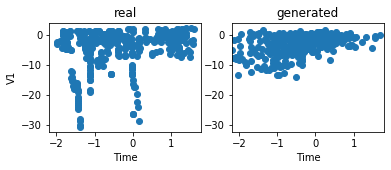

394 394
epoch: 380, Accuracy: 0.8959390862944162
[380/1001]	Loss_D: 0.4764	Loss_G: 1.6046	


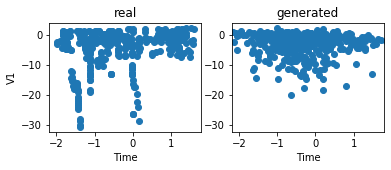

394 394
epoch: 390, Accuracy: 0.9060913705583756
[390/1001]	Loss_D: 0.4565	Loss_G: 1.7592	


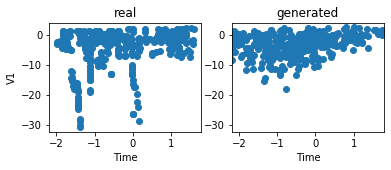

394 394
epoch: 400, Accuracy: 0.9213197969543148
[400/1001]	Loss_D: 0.5036	Loss_G: 1.5190	


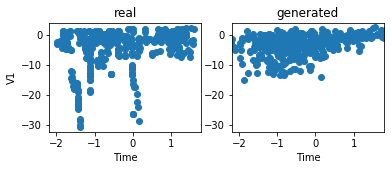

394 394
epoch: 410, Accuracy: 0.9390862944162437
[410/1001]	Loss_D: 0.4881	Loss_G: 1.4575	


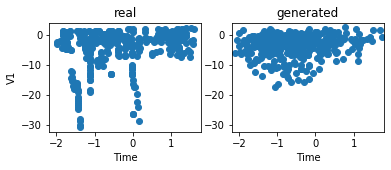

394 394
epoch: 420, Accuracy: 0.9137055837563451
[420/1001]	Loss_D: 0.4420	Loss_G: 1.4174	


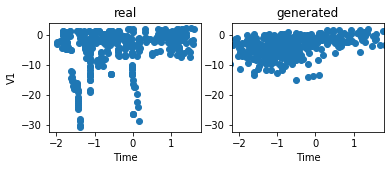

394 394
epoch: 430, Accuracy: 0.9086294416243654
[430/1001]	Loss_D: 0.4409	Loss_G: 1.7795	


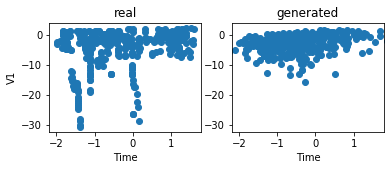

394 394
epoch: 440, Accuracy: 0.9314720812182741
[440/1001]	Loss_D: 0.4392	Loss_G: 1.5044	


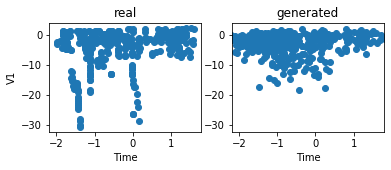

394 394
epoch: 450, Accuracy: 0.9238578680203046
[450/1001]	Loss_D: 0.4657	Loss_G: 2.0360	


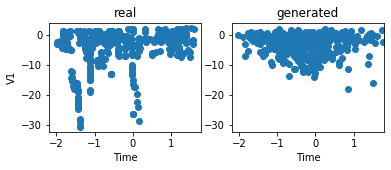

394 394
epoch: 460, Accuracy: 0.9060913705583756
[460/1001]	Loss_D: 0.3994	Loss_G: 2.0429	


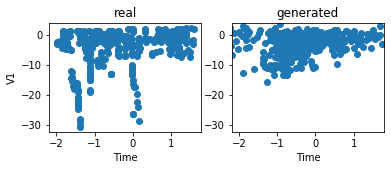

394 394
epoch: 470, Accuracy: 0.8807106598984772
[470/1001]	Loss_D: 0.5137	Loss_G: 1.8025	


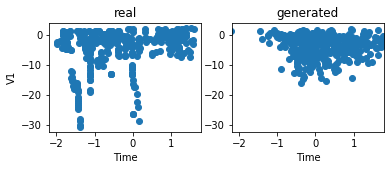

394 394
epoch: 480, Accuracy: 0.8908629441624365
[480/1001]	Loss_D: 0.4744	Loss_G: 1.8832	


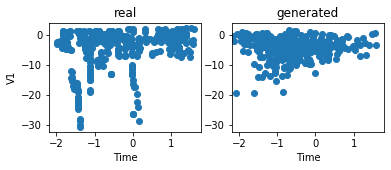

394 394
epoch: 490, Accuracy: 0.9314720812182741
[490/1001]	Loss_D: 0.4350	Loss_G: 1.5296	


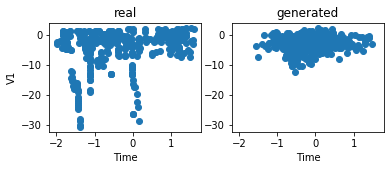

394 394
epoch: 500, Accuracy: 0.9568527918781726
[500/1001]	Loss_D: 0.4518	Loss_G: 1.9689	


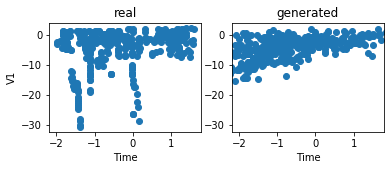

394 394
epoch: 510, Accuracy: 0.9060913705583756
[510/1001]	Loss_D: 0.4342	Loss_G: 1.8367	


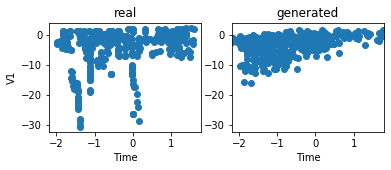

394 394
epoch: 520, Accuracy: 0.9365482233502538
[520/1001]	Loss_D: 0.4174	Loss_G: 1.6845	


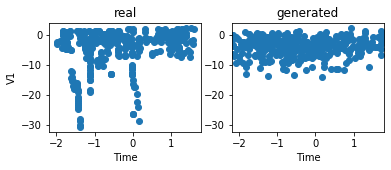

394 394
epoch: 530, Accuracy: 0.8984771573604061
[530/1001]	Loss_D: 0.4004	Loss_G: 1.9431	


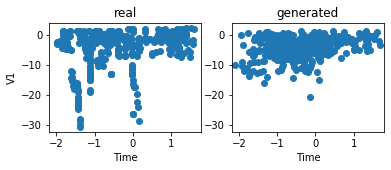

394 394
epoch: 540, Accuracy: 0.9060913705583756
[540/1001]	Loss_D: 0.4134	Loss_G: 1.9347	


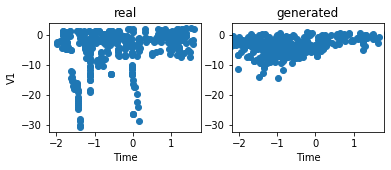

394 394
epoch: 550, Accuracy: 0.9086294416243654
[550/1001]	Loss_D: 0.4044	Loss_G: 2.0861	


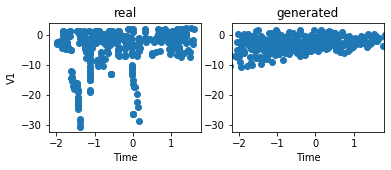

394 394
epoch: 560, Accuracy: 0.8934010152284264
[560/1001]	Loss_D: 0.3357	Loss_G: 2.2543	


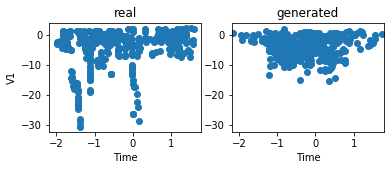

394 394
epoch: 570, Accuracy: 0.8604060913705583
[570/1001]	Loss_D: 0.5031	Loss_G: 2.2651	


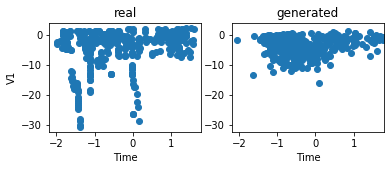

394 394
epoch: 580, Accuracy: 0.9187817258883249
[580/1001]	Loss_D: 0.3343	Loss_G: 2.2630	


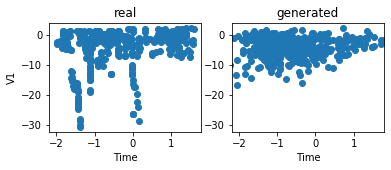

394 394
epoch: 590, Accuracy: 0.9137055837563451
[590/1001]	Loss_D: 0.3282	Loss_G: 2.6295	


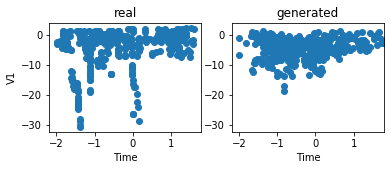

394 394
epoch: 600, Accuracy: 0.8756345177664975
[600/1001]	Loss_D: 0.3315	Loss_G: 2.1789	


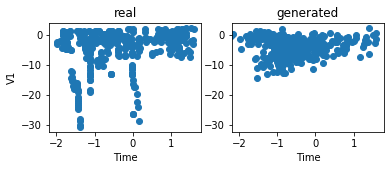

394 394
epoch: 610, Accuracy: 0.9111675126903553
[610/1001]	Loss_D: 0.3961	Loss_G: 2.0927	


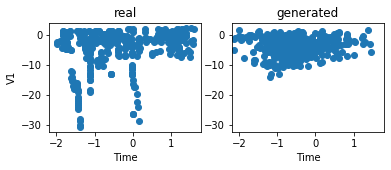

394 394
epoch: 620, Accuracy: 0.8959390862944162
[620/1001]	Loss_D: 0.3382	Loss_G: 2.0678	


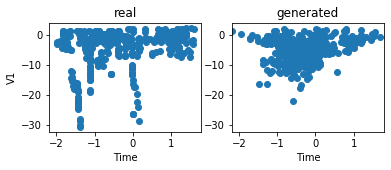

394 394
epoch: 630, Accuracy: 0.9035532994923858
[630/1001]	Loss_D: 0.3310	Loss_G: 2.1371	


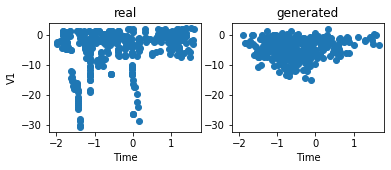

394 394
epoch: 640, Accuracy: 0.9416243654822335
[640/1001]	Loss_D: 0.5942	Loss_G: 2.3242	


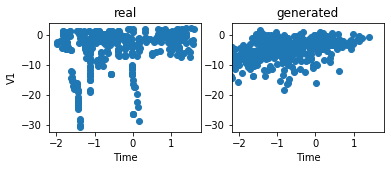

394 394
epoch: 650, Accuracy: 0.8857868020304569
[650/1001]	Loss_D: 0.3026	Loss_G: 2.3966	


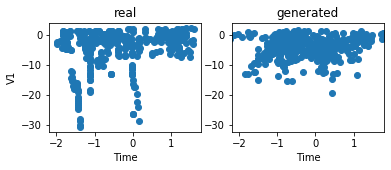

394 394
epoch: 660, Accuracy: 0.8426395939086294
[660/1001]	Loss_D: 0.7337	Loss_G: 1.8804	


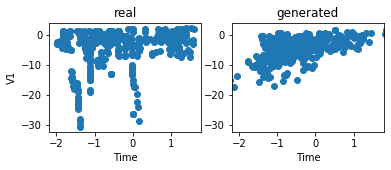

394 394
epoch: 670, Accuracy: 0.9060913705583756
[670/1001]	Loss_D: 0.4134	Loss_G: 2.2015	


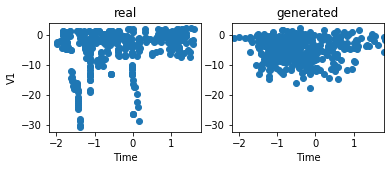

394 394
epoch: 680, Accuracy: 0.8324873096446701
[680/1001]	Loss_D: 0.2730	Loss_G: 2.3176	


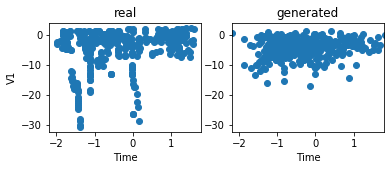

394 394
epoch: 690, Accuracy: 0.8934010152284264
[690/1001]	Loss_D: 0.3721	Loss_G: 2.2094	


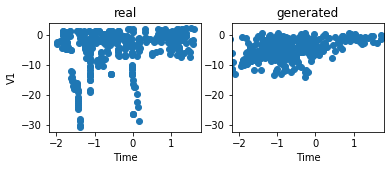

394 394
epoch: 700, Accuracy: 0.9035532994923858
[700/1001]	Loss_D: 0.3062	Loss_G: 2.6664	


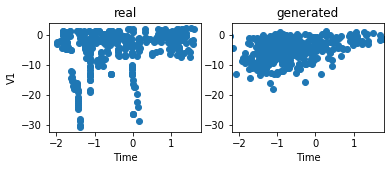

394 394
epoch: 710, Accuracy: 0.9010152284263959
[710/1001]	Loss_D: 0.2721	Loss_G: 2.7843	


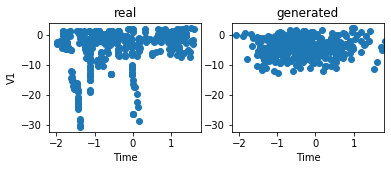

394 394
epoch: 720, Accuracy: 0.8934010152284264
[720/1001]	Loss_D: 0.3996	Loss_G: 2.5431	


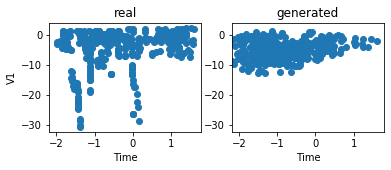

394 394
epoch: 730, Accuracy: 0.9314720812182741
[730/1001]	Loss_D: 0.3670	Loss_G: 2.5332	


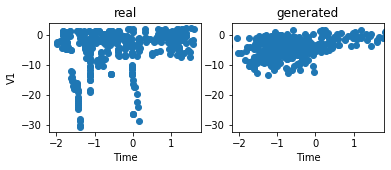

394 394
epoch: 740, Accuracy: 0.8730964467005076
[740/1001]	Loss_D: 0.2596	Loss_G: 2.9118	


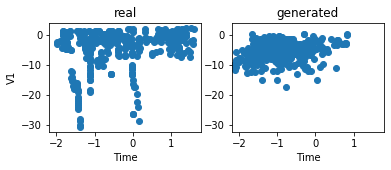

394 394
epoch: 750, Accuracy: 0.8959390862944162
[750/1001]	Loss_D: 0.2799	Loss_G: 2.6633	


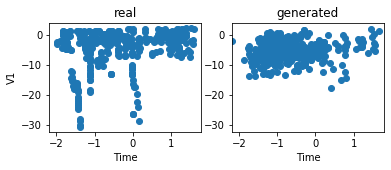

394 394
epoch: 760, Accuracy: 0.8705583756345178
[760/1001]	Loss_D: 0.2483	Loss_G: 2.6537	


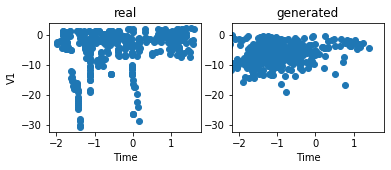

394 394
epoch: 770, Accuracy: 0.8984771573604061
[770/1001]	Loss_D: 0.3142	Loss_G: 2.9761	


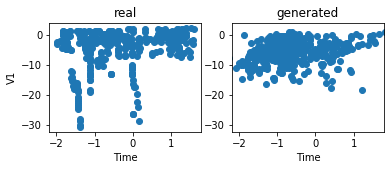

394 394
epoch: 780, Accuracy: 0.8451776649746193
[780/1001]	Loss_D: 0.4991	Loss_G: 3.0021	


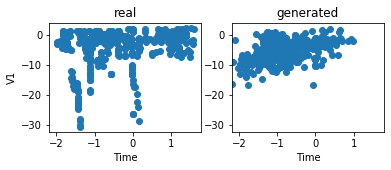

394 394
epoch: 790, Accuracy: 0.9035532994923858
[790/1001]	Loss_D: 0.3091	Loss_G: 3.0676	


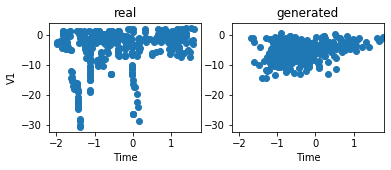

394 394
epoch: 800, Accuracy: 0.9035532994923858
[800/1001]	Loss_D: 0.2709	Loss_G: 2.8350	


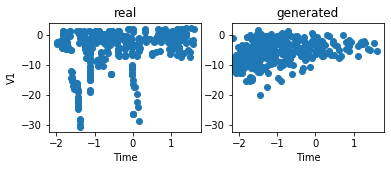

394 394
epoch: 810, Accuracy: 0.9035532994923858
[810/1001]	Loss_D: 0.2500	Loss_G: 2.9308	


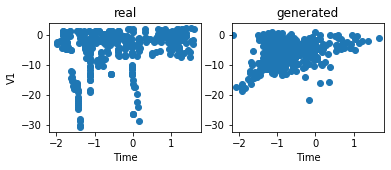

394 394
epoch: 820, Accuracy: 0.8883248730964467
[820/1001]	Loss_D: 0.2904	Loss_G: 2.8247	


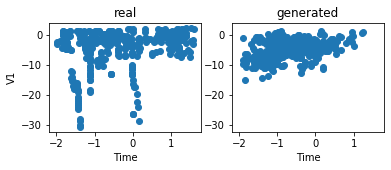

394 394
epoch: 830, Accuracy: 0.868020304568528
[830/1001]	Loss_D: 0.2369	Loss_G: 3.0149	


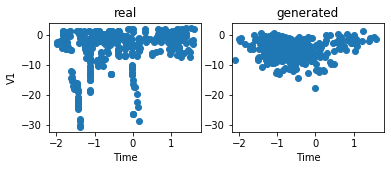

394 394
epoch: 840, Accuracy: 0.8756345177664975
[840/1001]	Loss_D: 0.2860	Loss_G: 2.6163	


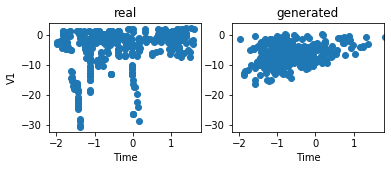

394 394
epoch: 850, Accuracy: 0.8781725888324873
[850/1001]	Loss_D: 0.3315	Loss_G: 2.8038	


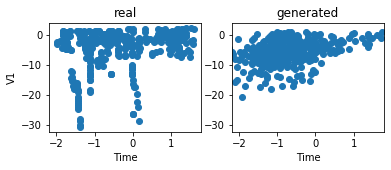

394 394
epoch: 860, Accuracy: 0.8984771573604061
[860/1001]	Loss_D: 0.2351	Loss_G: 2.8716	


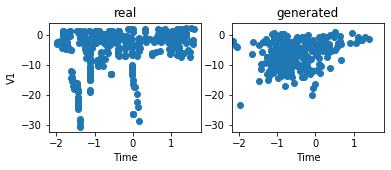

394 394
epoch: 870, Accuracy: 0.8959390862944162
[870/1001]	Loss_D: 0.3082	Loss_G: 2.8208	


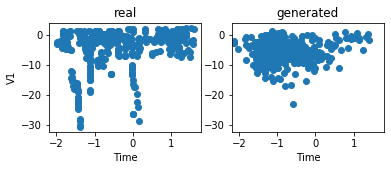

394 394
epoch: 880, Accuracy: 0.9238578680203046
[880/1001]	Loss_D: 0.5106	Loss_G: 3.2877	


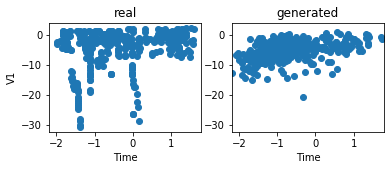

394 394
epoch: 890, Accuracy: 0.8604060913705583
[890/1001]	Loss_D: 0.2378	Loss_G: 2.9410	


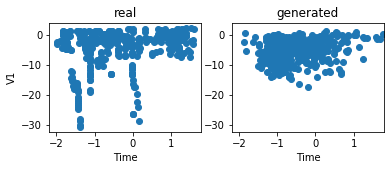

394 394
epoch: 900, Accuracy: 0.9086294416243654
[900/1001]	Loss_D: 0.2494	Loss_G: 3.0473	


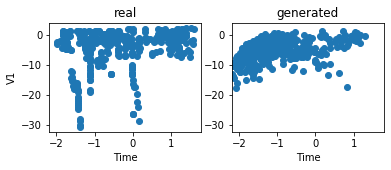

394 394
epoch: 910, Accuracy: 0.8756345177664975
[910/1001]	Loss_D: 0.3903	Loss_G: 3.7297	


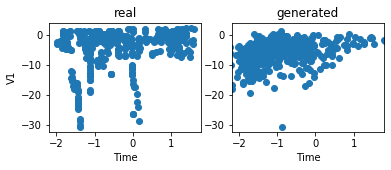

394 394
epoch: 920, Accuracy: 0.8908629441624365
[920/1001]	Loss_D: 0.2261	Loss_G: 2.9230	


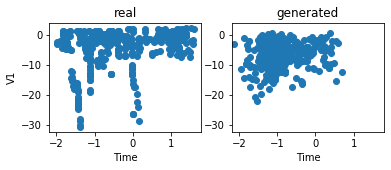

394 394
epoch: 930, Accuracy: 0.9263959390862944
[930/1001]	Loss_D: 0.2965	Loss_G: 3.4376	


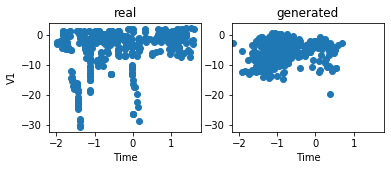

394 394
epoch: 940, Accuracy: 0.8705583756345178
[940/1001]	Loss_D: 0.2082	Loss_G: 3.0975	


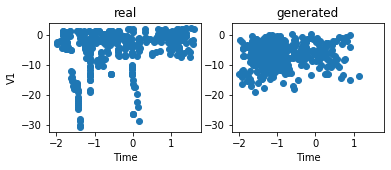

394 394
epoch: 950, Accuracy: 0.9010152284263959
[950/1001]	Loss_D: 0.2171	Loss_G: 2.8589	


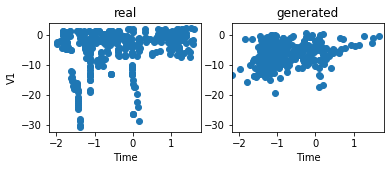

394 394
epoch: 960, Accuracy: 0.8959390862944162
[960/1001]	Loss_D: 0.2326	Loss_G: 2.8981	


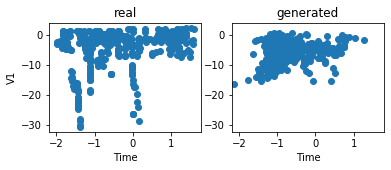

394 394
epoch: 970, Accuracy: 0.8705583756345178
[970/1001]	Loss_D: 0.3182	Loss_G: 3.8432	


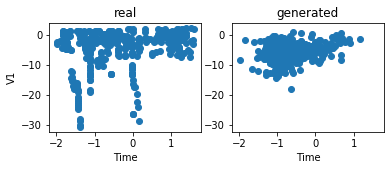

394 394
epoch: 980, Accuracy: 0.8883248730964467
[980/1001]	Loss_D: 0.2791	Loss_G: 3.2165	


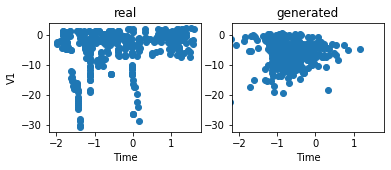

394 394
epoch: 990, Accuracy: 0.9035532994923858
[990/1001]	Loss_D: 0.2480	Loss_G: 2.9892	


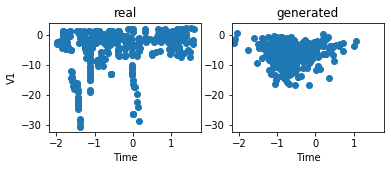

394 394
epoch: 1000, Accuracy: 0.9263959390862944
[1000/1001]	Loss_D: 0.2682	Loss_G: 2.6988	


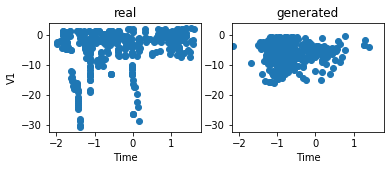

It took  77.8176257610321


In [44]:
xgblosses, D_losses, G_losses, D_RealLosses, D_FakeLosses, generated_data, real_data_list = gan.train(dataloader, randomNoise_dim = 32, hidden_dim = 64, realData_dim =dataloader.dataset.features.size(1), lr = 0.002, num_epochs=1000, feature_cols=feature_cols, device='cpu')

In [45]:
for i in range(xgblosses.size):
    if np.round(xgblosses[i],6) == np.round(min(xgblosses[10:]),6):
        best_round = i*10
        print(best_round)

680


0.8324873096446701


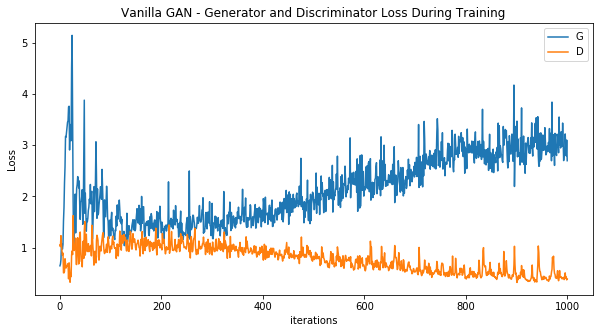

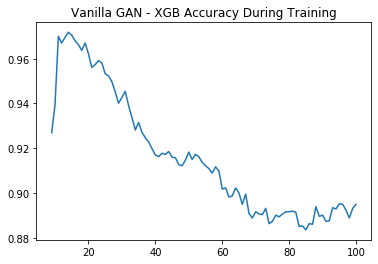

In [46]:
w=10
print(min(xgblosses[10:]))
plt.figure(figsize=(10,5))
plt.title(f"Vanilla GAN - Generator and Discriminator Loss During Training")
b = pd.DataFrame(G_losses[:]).rolling(w).mean()
# c = pd.DataFrame(D_RealLosses[:]).rolling(w).mean()
# d = pd.DataFrame(D_FakeLosses[:]).rolling(w).mean()
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
# plt.plot(b,label="G")
# plt.plot(c,label="D")
# plt.plot(d,label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f'reports/figures/gan/GAN_Time.png')
plt.show()


a = pd.DataFrame(xgblosses[:]).rolling(w).mean()
plt.title(f"Vanilla GAN - XGB Accuracy During Training")
plt.plot(a)
plt.savefig(f'reports/figures/gan/xgblosses_GAN_Time.png')
plt.show()

In [47]:
amount=train.shape[0]
device='cpu'

In [48]:
train.shape[0]

227845

In [49]:
randomNoise_dim = 32; hidden_dim = 64; realData_dim =dataloader.dataset.features.size(1)

In [50]:
more_data = gan.generate_data(best_round, randomNoise_dim, hidden_dim, realData_dim, amount, 'cpu')

In [51]:
more_data = more_data.detach().numpy()

In [52]:
b = np.ones((more_data.shape[0],more_data.shape[1]+1))
b[:,:-1] = more_data

In [53]:
b.shape

(227845, 31)

In [54]:
label_col = ['Class']

In [55]:
df_generatedData = pd.DataFrame(b, columns = feature_cols + label_col)
df_generatedData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.479892,-3.643609,2.726140,-4.215187,3.032965,-2.655427,-1.524990,-3.914181,1.132453,-1.674006,...,0.542611,0.034457,-0.069140,-0.107014,-0.128429,-0.528916,0.184891,0.617281,-0.238000,1.0
1,0.026682,-1.914054,2.018239,-3.698739,0.779048,-1.787780,-1.276489,-2.237602,0.340868,-0.979522,...,0.256409,0.184672,0.132953,-0.258170,0.145887,-0.310743,0.467753,0.304543,-0.250999,1.0
2,-0.281254,-5.312638,3.159728,-6.180707,5.101904,-5.421454,-1.795581,-6.788542,3.009359,-3.697026,...,1.124111,0.541328,-0.439825,0.152126,-0.032939,-0.208911,0.159192,0.252394,-0.225213,1.0
3,-0.318509,-2.728734,5.610638,-9.059752,7.606590,-4.479266,-4.153514,-8.322268,1.707961,-4.186726,...,1.116746,-0.433339,-0.761518,0.085433,-0.244827,-0.367492,1.980432,-0.175912,0.150022,1.0
4,-0.386153,-2.529407,2.758400,-6.070486,4.488273,-4.570802,-2.090179,-7.609455,2.158981,-3.848770,...,1.252774,0.968970,0.044655,0.314823,-0.119421,-0.076196,1.604843,0.687886,-0.089998,1.0


In [56]:
train = train.append(df_generatedData)
train = train.sample(frac=1)

In [57]:
train_y = train.Class
train_X = train
train_X.drop('Class', axis=1, inplace=True)

In [58]:
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [59]:
train_y.shape

(455690,)

In [60]:
start_time = time.time()
dtrain = xgb.DMatrix(train_X, train_y, feature_names=feature_cols)
dtest = xgb.DMatrix(test_X, feature_names=feature_cols)

results_dict = {}

param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }

model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = np.round(model.predict(dtest))
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

C:\Users\chinne\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\chinne\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Time elapsed to train:  51.846418619155884


In [61]:
print('---' * 45)
print('XGBoost ROC/AUC: {:.6f}'.format(roc_auc_score(test_y, preds)))
print('Recall Score: {:.6f}'.format(recall_score(test_y, preds)))
print('Precision Score: {:.6f}'.format(precision_score(test_y, preds)))
print('F1 Score: {:.6f}'.format(f1_score(test_y, preds)))
print('Accuracy Score: {:.6f}'.format(accuracy_score(test_y, preds)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
XGBoost ROC/AUC: 0.892366
Recall Score: 0.959184
Precision Score: 0.009387
F1 Score: 0.018592
Accuracy Score: 0.825779
---------------------------------------------------------------------------------------------------------------------------------------
